In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, pi
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
# from tqdm import tqdm_notebook
from tqdm.notebook import tqdm as tqdm_notebook

In [25]:
l = 1
a = 100
delta = l/20
Nz = 100
zE = np.linspace(-l, l, Nz)
h = zE[1] - zE[0]
zH = np.linspace(-l + h/2, l + h/2, Nz)
T = 1.5
Nt = 100
tau = T/Nt
r = tau/h
print("Число Куранта:", r)

Число Куранта: 0.7424999999999993


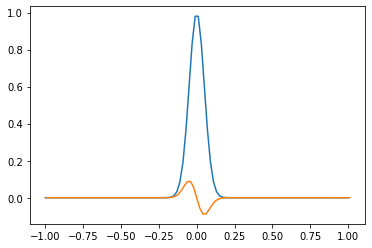

In [26]:
def sigma(z):
    if(-l < z < -l + delta):
        return a * ((z + l - delta)/delta)**2
    elif(l - delta < z < l):
        return a * ((z - l + delta)/delta)**2
    else:
        return 0
l1 = delta    
def f(z):
    return exp(-z**2/2/l1**2)

def fd(z):
    return -z/l1**2 * exp(-z**2/2/l1**2)

E = np.array([f(z) for z in zE])
H = tau/2 * np.array([fd(z) for z in zH])
sigmaE = np.array([sigma(z) for z in zE])
sigmaH = np.array([sigma(z) for z in zH])

plt.plot(zE, E)
plt.plot(zH, H)

In [27]:
fig, ax = plt.subplots(figsize = (12, 7))
ax.grid(True)
ln1, = plt.plot([], [], color = 'g', linestyle = '-', label = "E numerical from Maxwell PML")
ln2, = plt.plot([], [], color = 'c', linestyle = ':', label = "H numerical from Maxwell PML")
ln3, = plt.plot([], [], color = 'r', linestyle = '-', label = "E precise")

ln1.set_data(zE, E)
ln2.set_data(zH, H)
ln3.set_data(zE, E)

def new_layer(E, H):
    E_cur = np.zeros(Nz)
    H_cur = np.zeros(Nz)
    for j in range(1, Nz - 1):
        E_cur[j] = (E[j] * (1 - 2*pi*sigmaE[j] * tau) + r * (H[j] - H[j - 1]))/(1 + 2*pi*sigmaE[j] * tau)
    for j in range(Nz - 1):    
        H_cur[j] = ((1 - 2*pi*sigmaH[j] * tau) * H[j] + r * (E_cur[j+1] - E_cur[j])) / (1 + 2*pi*sigmaH[j] * tau)
    
    return E_cur, H_cur

def precise_solution(nt):
    E_pr = np.array([(f(z - nt*tau) + f(z + nt*tau))/2 for z in zE])
    return E_pr

def init():
    ax.set_xlim(-l, l)
    ax.set_ylim(-1, 1)
    ax.legend()
    return ln1,

def update(nt):
    global E, H
    E, H = new_layer(E, H)
    E_pr = precise_solution(nt + 1)
    ln1.set_data(zE, E)
    ln2.set_data(zH, H)
    ln3.set_data(zE, E_pr)
    return ln1,

anim = FuncAnimation(fig, update, frames=tqdm_notebook(range(Nt)), init_func = init, interval = 100, blit=True)
html5video = anim.to_html5_video()
plt.close()
HTML(html5video)